# MLB Game Prediction
Parker Jackson

## Accomplishments
- Data Preparation: Successfully cleaned and preprocessed MLB game data (2015-2025)
- Feature Engineering: Created differential features (diff_win_pct, diff_run_diff, etc.) to capture home team advantage
- EDA Complete: Analyzed correlations, temporal patterns, weather impacts, and park factors
- Baseline Established: ~53% accuracy from naive "always predict home win" approach
- Model Planning: Identified baseline (Logistic Regression) and advanced models (Random Forest, XGBoost)

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [87]:
df = pd.read_csv("data/mlb_2015_2025_dataset.csv", index_col=0)

# optimize and change data types
df['date'] = pd.to_datetime(df['date'])                                                 # ensure dates are proper type
df = df[df['condition'] != 'Unknown']
df["condition"] = df["condition"].astype("category")                                    # weather conditions --> category
df["home_team"] = df["home_team"].astype("category")                                    # team id's and venue id are not numeric --> category
df["away_team"] = df["away_team"].astype("category")
df["venue_id"] = df["venue_id"].astype("category")
int_cols = df.select_dtypes(include=["int"])
df[int_cols.columns] = df[int_cols.columns].apply(pd.to_numeric, downcast="integer")    # downcast ints
float_cols = df.select_dtypes(include=["float"])
df[float_cols.columns] = df[float_cols.columns].apply(pd.to_numeric, downcast="float")  # downcast floats

# Load and merge park factors
park_factors = pd.read_csv("data/venue_park_factors.csv")
park_factors['venue_id'] = park_factors['venue_id'].astype("category")

# Merge park factors with main dataset
df = df.merge(
    park_factors[['venue_id', 'park_factor']],
    on='venue_id',
    how='left'
)

# Fill any missing park factors with neutral value (100)
df['park_factor'] = df['park_factor'].fillna(100)

# Normalize park factor to be centered around 1.0 instead of 100
df['park_factor'] = df['park_factor'] / 100

# ensure value ranges are correct
df['home_games_last_7'] = df['home_games_last_7'].clip(upper=7)                         # ensure "last 7" can't be greater than 7
df['away_games_last_7'] = df['away_games_last_7'].clip(upper=7)

# add values
# df["away_win"] = df["home_win"] * -1 + 1
df['diff_wins_last_5']  = df['home_wins_last_5'] - df['away_wins_last_5']
df['diff_run_diff']     = df['home_run_diff'] - df['away_run_diff']                         # difference in run differentials
df['diff_avg']          = df['home_avg'] - df['away_avg']                                        # difference in batting average
df['diff_ops']          = df['home_ops'] - df['away_ops']                                        # difference in OPS
df['diff_era']          = df['home_starter_era'] - df['away_starter_era']                        # difference in starter ERA
df['diff_whip']         = df['home_starter_whip'] - df['away_starter_whip']                     # difference in starter WHIP
df['diff_rest']         = df['home_rest'] - df['away_rest']                                     # difference in rest days
df['diff_games_last_7'] = df['home_games_last_7'] - df['away_games_last_7']             # difference in games in last 7 days
df['diff_win_pct']      = df['home_win_pct'] - df['away_win_pct']                            # difference in win percentage

del int_cols, float_cols

---
# Modeling
## Logistic Regression

In [67]:
# Select features for logistic regression (avoid multicollinearity)
# Using differential features + weather/rest
features = [
    'temp',
    'wind_speed',
    'diff_run_diff',
    'diff_ops',
    'diff_whip',
    'diff_wins_last_10',
    'diff_games_last_7',
    'park_factor'
]

# Prepare data
X = df[features]
y = df['home_win']

# Split by time to avoid data leakage
# Training: 2015-2023, Test: 2024-2025
train_mask = df['date'].dt.year < 2024
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Grid Search
log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    log_reg_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

log_reg_grid.fit(X_train_scaled, y_train)

print("Logistic Regression - Best Parameters:")
print(log_reg_grid.best_params_)
print(f"Best CV ROC-AUC: {log_reg_grid.best_score_:.4f}")

# Evaluate best model
y_pred_grid = log_reg_grid.predict(X_test_scaled)
y_pred_proba_grid = log_reg_grid.predict_proba(X_test_scaled)[:, 1]
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_grid):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_grid):.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Logistic Regression - Best Parameters:
{'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best CV ROC-AUC: 0.5768

Test Accuracy: 0.5524
Test ROC-AUC: 0.5665


Accuracy on test is better than naively guessing and is in the expected range for most MLB models.

In [68]:
# Get the best model from GridSearchCV
best_log_reg = log_reg_grid.best_estimator_

# Feature coefficients
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': best_log_reg.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Importance (Coefficients):")
feature_importance


Feature Importance (Coefficients):


,feature,coefficient
2,diff_run_diff,0.187433
4,diff_whip,-0.047557
5,diff_wins_last_10,0.044645
0,temp,0.000000
1,wind_speed,0.000000
3,diff_ops,0.000000
6,diff_games_last_7,0.000000
7,park_factor,0.000000


As expected, Run differential coming into the game is the biggest differentiator in determining which team wins.

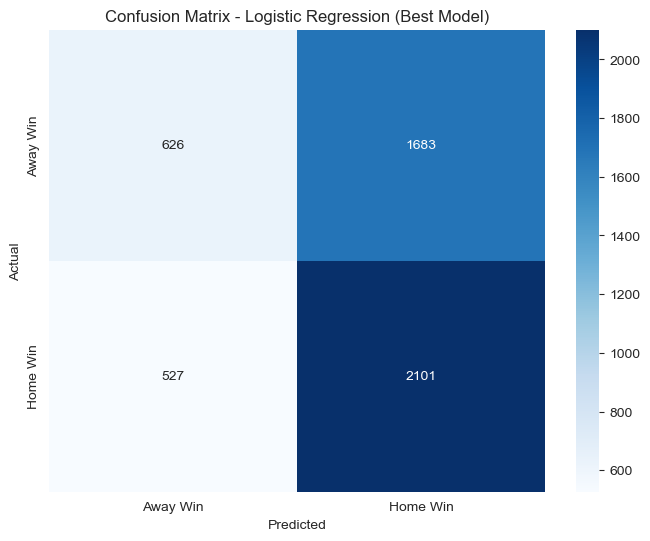

In [69]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
plt.title('Confusion Matrix - Logistic Regression (Best Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The model is a lot better at predicting the Home team than the away team.

---
## Decision Tree

In [70]:
# Decision Tree Grid Search
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [25, 50, 100],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

print("Decision Tree - Best Parameters:")
print(dt_grid.best_params_)
print(f"Best CV ROC-AUC: {dt_grid.best_score_:.4f}")

# Evaluate best model
y_pred_dt_grid = dt_grid.predict(X_test)
y_pred_proba_dt_grid = dt_grid.predict_proba(X_test)[:, 1]
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_dt_grid):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_dt_grid):.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Decision Tree - Best Parameters:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 50}
Best CV ROC-AUC: 0.5722

Test Accuracy: 0.5499
Test ROC-AUC: 0.5617


DT gave a similar result to LogReg. Slightly worse on test than LogReg.

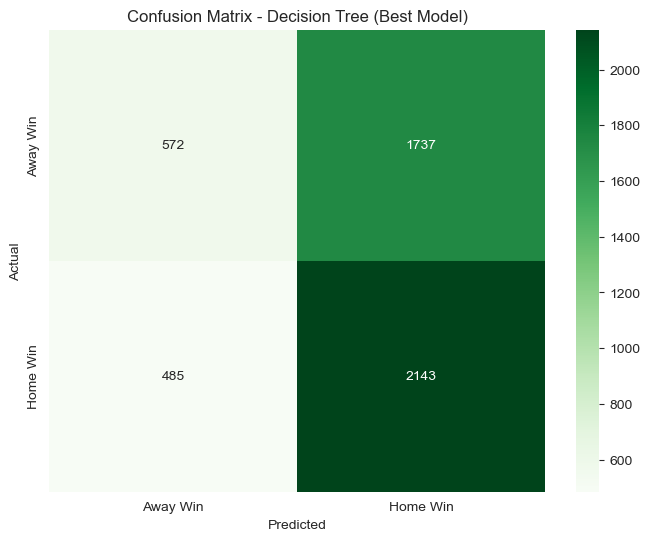

In [71]:
# Get the best decision tree model
best_dt = dt_grid.best_estimator_

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
plt.title('Confusion Matrix - Decision Tree (Best Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

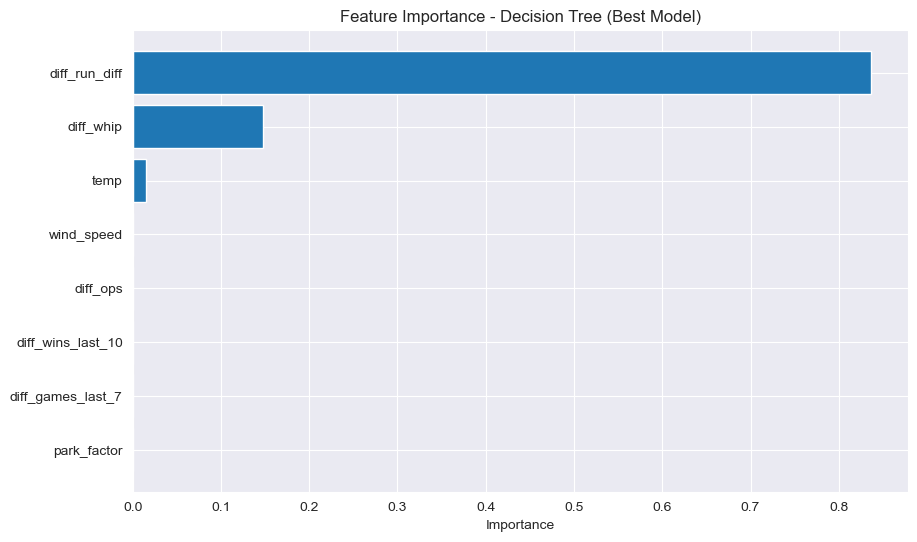

In [72]:
# Feature Importance
feature_importance_dt = pd.DataFrame({
    'feature': features,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_dt['feature'], feature_importance_dt['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Decision Tree (Best Model)')
plt.gca().invert_yaxis()
plt.show()

In [73]:
print("\nFeature Importance:")
feature_importance_dt


Feature Importance:


,feature,importance
2,diff_run_diff,0.836127
4,diff_whip,0.148272
0,temp,0.015601
1,wind_speed,0.000000
3,diff_ops,0.000000
5,diff_wins_last_10,0.000000
6,diff_games_last_7,0.000000
7,park_factor,0.000000


Again, we see Run Differential as the dominant factor in determining this. Diff in WHIP makes a bigger impact than in LogReg. Temp comes into the picture as well.

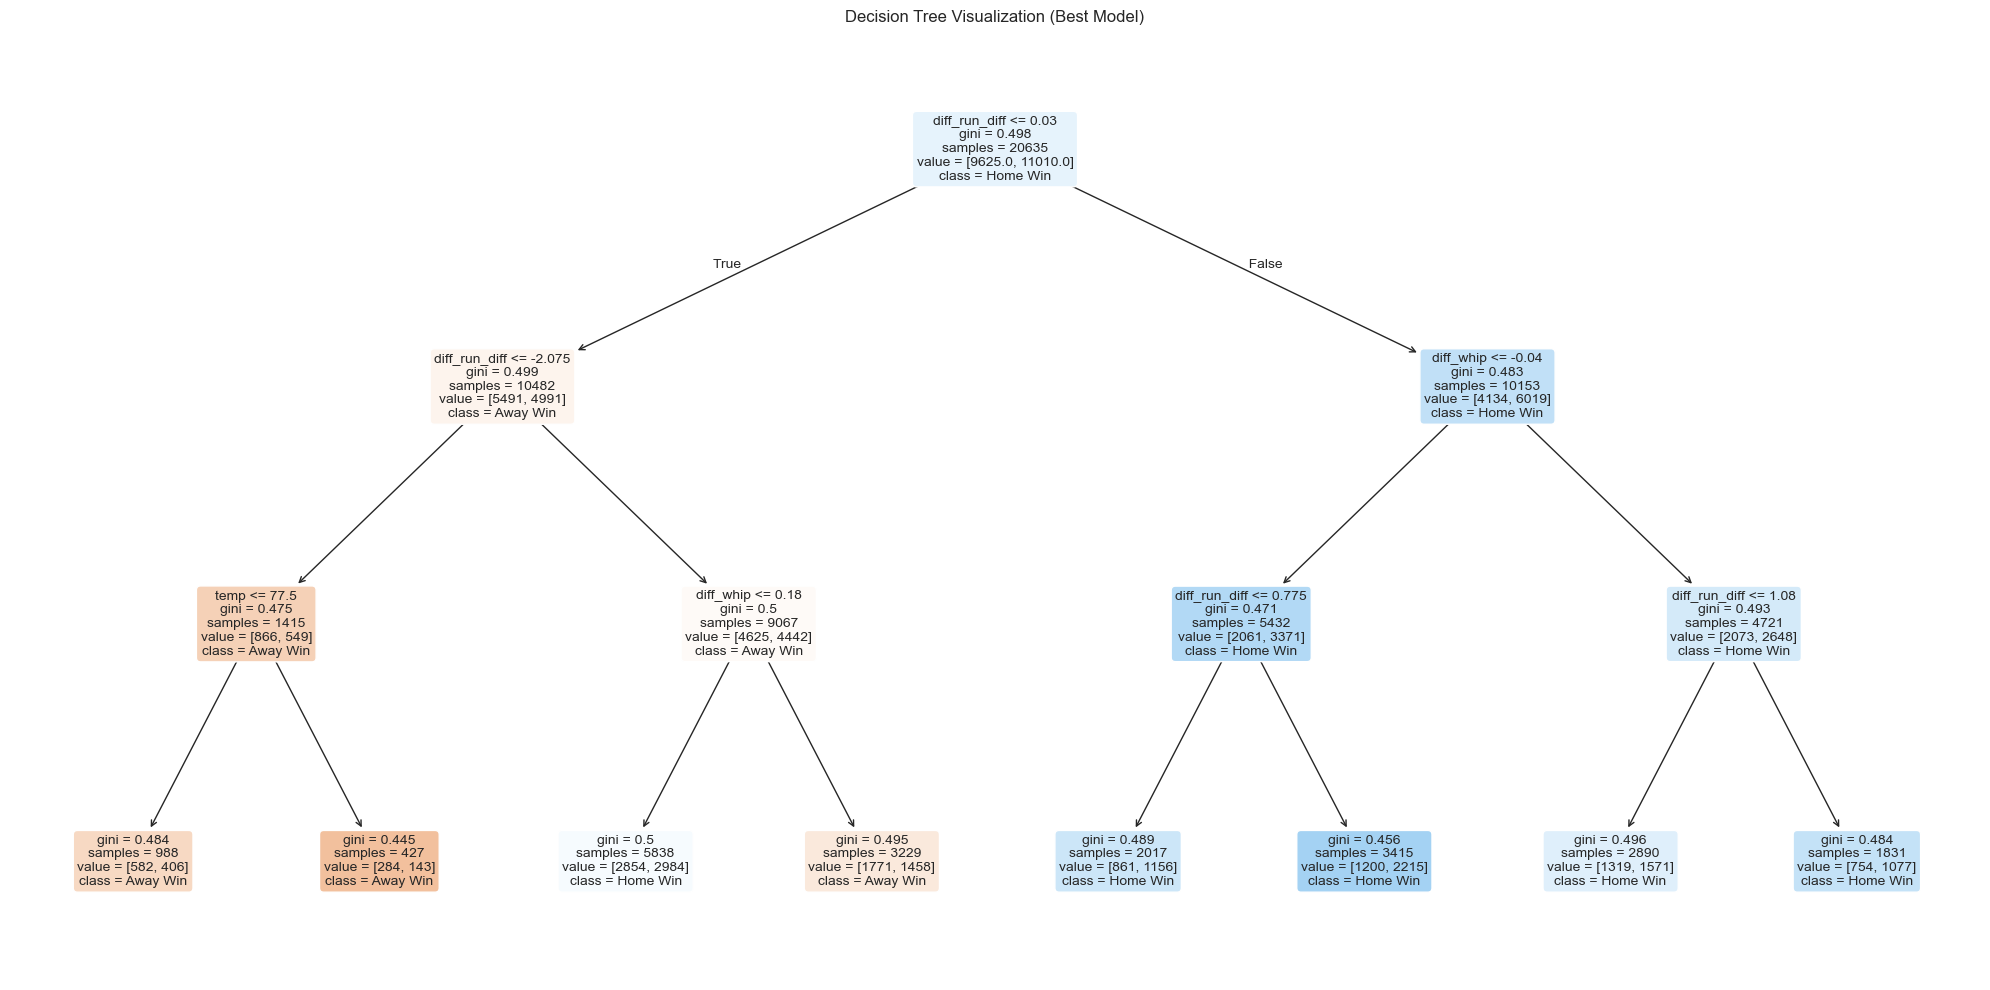

In [74]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=features,
    class_names=['Away Win', 'Home Win'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree Visualization (Best Model)')
plt.tight_layout()
plt.show()

---
## Random Forest

In [79]:
# Random Forest Randomized Search (faster)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [25, 50, 100],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=20,  # Try only 20 random combinations instead of all 144
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random.fit(X_train, y_train)

print("Random Forest - Best Parameters:")
print(rf_random.best_params_)
print(f"Best CV ROC-AUC: {rf_random.best_score_:.4f}")

# Evaluate best model
y_pred_rf_grid = rf_random.predict(X_test)
y_pred_proba_rf_grid = rf_random.predict_proba(X_test)[:, 1]
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_rf_grid):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf_grid):.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Random Forest - Best Parameters:
{'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 5}
Best CV ROC-AUC: 0.5806

Test Accuracy: 0.5580
Test ROC-AUC: 0.5687


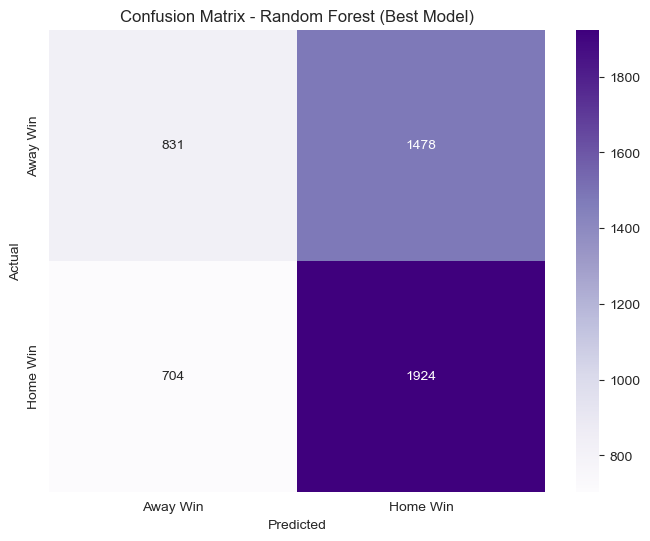

In [76]:
# Get the best random forest model
best_rf = rf_random.best_estimator_

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_grid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
plt.title('Confusion Matrix - Random Forest (Best Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

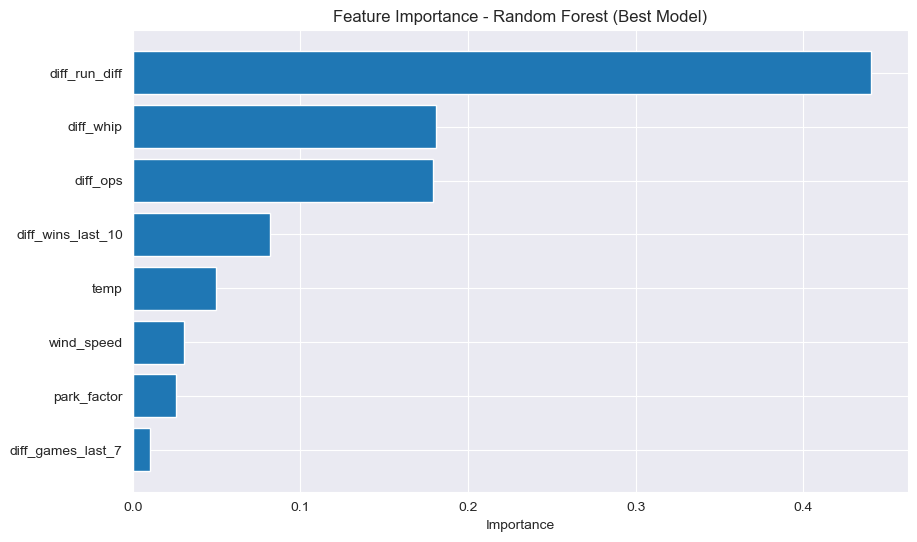

In [77]:
# Feature Importance
feature_importance_rf = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'], feature_importance_rf['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest (Best Model)')
plt.gca().invert_yaxis()
plt.show()

In [78]:
print("\nFeature Importance:")
print(feature_importance_rf)


Feature Importance:
             feature  importance
2      diff_run_diff    0.440211
4          diff_whip    0.181234
3           diff_ops    0.179404
5  diff_wins_last_10    0.082195
0               temp    0.049707
1         wind_speed    0.030903
7        park_factor    0.025787
6  diff_games_last_7    0.010559


We see a couple more factors getting action here. Run differential is again the dominant term, however, WHIP, OPS, and wins last 10 (in difference) have stepped up. 

---
## XGBoost

In [82]:
# XGBoost Randomized Search
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    xgb_params,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train, y_train)

print("XGBoost - Best Parameters:")
print(xgb_random.best_params_)
print(f"Best CV ROC-AUC: {xgb_random.best_score_:.4f}")

# Evaluate best model
y_pred_xgb = xgb_random.predict(X_test)
y_pred_proba_xgb = xgb_random.predict_proba(X_test)[:, 1]
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGBoost - Best Parameters:
{'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best CV ROC-AUC: 0.5804

Test Accuracy: 0.5530
Test ROC-AUC: 0.5684


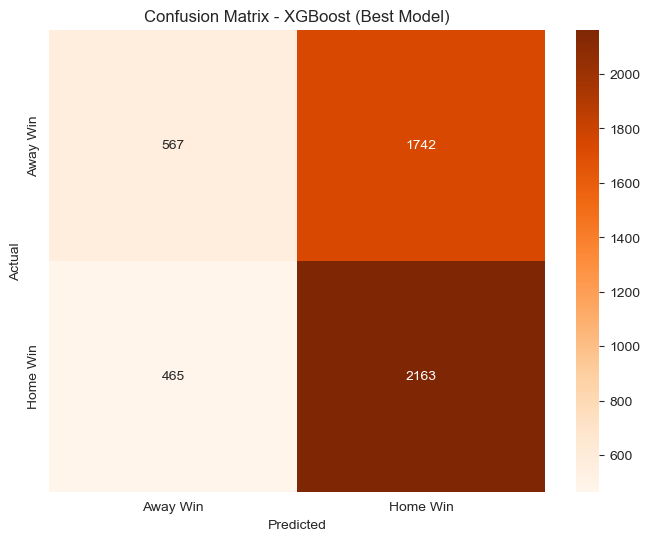

In [83]:
# Get the best XGBoost model
best_xgb = xgb_random.best_estimator_

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
plt.title('Confusion Matrix - XGBoost (Best Model)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

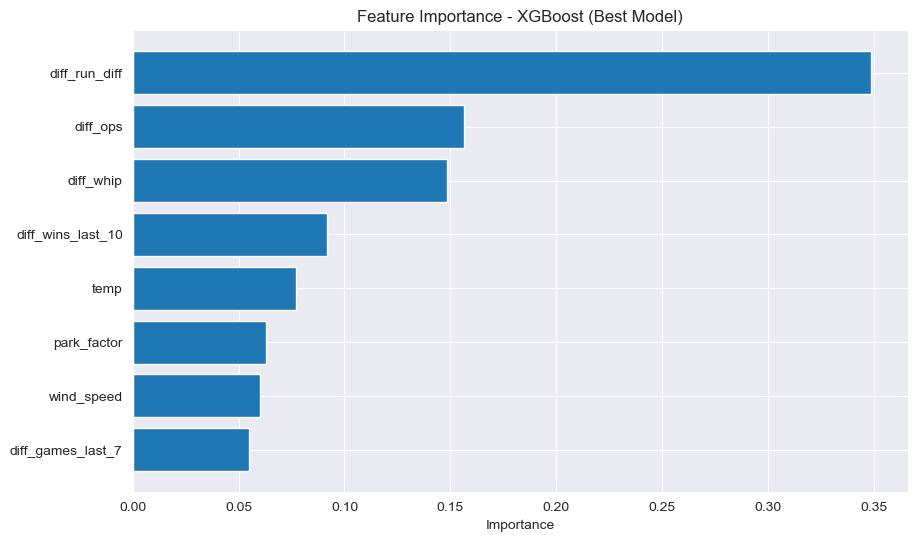

In [85]:
# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'feature': features,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['feature'], feature_importance_xgb['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost (Best Model)')
plt.gca().invert_yaxis()
plt.show()

In [86]:
print("\nFeature Importance:")
print(feature_importance_xgb)


Feature Importance:
             feature  importance
2      diff_run_diff    0.348402
3           diff_ops    0.156256
4          diff_whip    0.148301
5  diff_wins_last_10    0.091780
0               temp    0.077201
7        park_factor    0.062903
1         wind_speed    0.060232
6  diff_games_last_7    0.054926


Similar to the Random Forest feature importances, however, there is less emphasis on Run Differential. Some of the factors towards the end of the list got more involved in the XGBoost model.